<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/03-Deep-Learning/notebooks/07-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

2023-07-20 21:16:21.623850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from sklearn.metrics import mean_squared_error
import math

In [3]:
date_parser = lambda x: pd.to_datetime(x, format='%d-%b-%y')

df_sp500 = pd.read_csv('data/index-sp-500-ok.csv', parse_dates=[0], index_col=0)

display(df_sp500.head())
print(df_sp500.shape)

df_sp_bmv_ipc = pd.read_csv('data/index-sp-bmv-ipc-mxn.csv', parse_dates=[0], index_col=0)
display(df_sp_bmv_ipc.head())
print(df_sp_bmv_ipc.shape)

#df_sp_bmv_total = pd.read_csv('data/index-bmv-total-mexico-tr-mxn.csv', parse_dates=[0], index_col=0)
#display(df_sp_bmv_total.head())
#print(df_sp_bmv_total.shape)

df_sp_global_bmi = pd.read_csv('data/index-global-bmi.csv', parse_dates=[0], index_col=0)
display(df_sp_global_bmi.head())
print(df_sp_global_bmi.shape)




/tmp/ipykernel_7326/3232543393.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sp500 = pd.read_csv('data/index-sp-500-ok.csv', parse_dates=[0], index_col=0)


,S&P 500 (TR)
Index Name,
2023-07-18,9790.199590
2023-07-17,9721.025524
2023-07-14,9683.685534
2023-07-13,9693.297790
2023-07-12,9610.874778


(8528, 1)


/tmp/ipykernel_7326/3232543393.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sp_bmv_ipc = pd.read_csv('data/index-sp-bmv-ipc-mxn.csv', parse_dates=[0], index_col=0)


,S&P/BMV IPC
Index Name,
2023-07-18,54036.27448
2023-07-17,53623.26734
2023-07-14,53770.80282
2023-07-13,54244.01314
2023-07-12,53956.70953


(11188, 1)


/tmp/ipykernel_7326/3232543393.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sp_global_bmi = pd.read_csv('data/index-global-bmi.csv', parse_dates=[0], index_col=0)


,S&P Global BMI (USD)
Index Name,
2023-07-18,341.263545
2023-07-17,339.272722
2023-07-14,338.868883
2023-07-13,338.992279
2023-07-12,335.305709


(7448, 1)


In [4]:
merged_df = pd.merge(df_sp500, df_sp_bmv_ipc, on='Index Name', how='outer')
display(merged_df.head())

,S&P 500 (TR),S&P/BMV IPC
Index Name,,
2023-07-18,9790.199590,54036.27448
2023-07-17,9721.025524,53623.26734
2023-07-14,9683.685534,53770.80282
2023-07-13,9693.297790,54244.01314
2023-07-12,9610.874778,53956.70953


In [5]:
#final_df = pd.merge(merged_df, df_sp_global_bmi, on='Index Name', how='outer')
#display(merged_df.head())

In [6]:
#final_df = pd.merge(merged_df, df_sp_bmv_total, on='Index Name', how='outer')
#display(final_df.head())

In [7]:
final_df = merged_df

In [8]:
print(final_df.shape)
final_df.isna().sum()

(11437, 2)


S&P 500 (TR)    2909
S&P/BMV IPC      249
dtype: int64

In [9]:
data=final_df.dropna()
data.shape

(8279, 2)

In [10]:
data.index.name='date'
data

,S&P 500 (TR),S&P/BMV IPC
date,,
2023-07-18,9790.199590,54036.27448
2023-07-17,9721.025524,53623.26734
2023-07-14,9683.685534,53770.80282
2023-07-13,9693.297790,54244.01314
2023-07-12,9610.874778,53956.70953
...,...,...
1989-09-15,366.855913,417.97400
1989-09-14,364.827440,415.63700
1989-09-13,367.250190,411.60700


In [11]:
#dataClean = data.rename(columns = {'S&P 500 (TR)':'sp500', 'S&P/BMV IPC':'spbmvipc', 'S&P/BMV Total Mexico Index (MXN) TR':'spbmvtotal'})
dataClean = data.copy()
print(dataClean.head())
print(dataClean.shape)

            S&P 500 (TR)  S&P/BMV IPC
date                                 
2023-07-18   9790.199590  54036.27448
2023-07-17   9721.025524  53623.26734
2023-07-14   9683.685534  53770.80282
2023-07-13   9693.297790  54244.01314
2023-07-12   9610.874778  53956.70953
(8279, 2)


In [12]:
dataClean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8279 entries, 2023-07-18 to 1989-09-11
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   S&P 500 (TR)  8279 non-null   float64
 1   S&P/BMV IPC   8279 non-null   float64
dtypes: float64(2)
memory usage: 194.0 KB


In [13]:
dataClean.iloc[0]

S&P 500 (TR)     9790.19959
S&P/BMV IPC     54036.27448
Name: 2023-07-18 00:00:00, dtype: float64

In [14]:
dataClean.loc['2023-02-03']

S&P 500 (TR)     8820.465947
S&P/BMV IPC     54049.054010
Name: 2023-02-03 00:00:00, dtype: float64

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

i = 0
for c in list(dataClean):
    axs[i].plot(dataClean[c])
    axs[i].set_title(c)
    i += 1
plt.show()

In [ ]:
# si queremos sacar los datos del archivo exportado:
if False:
    df = pd.read_csv('data/f75e266e-d3df-4d9d-8c0e-c0174b6ccc24_Data.csv', index_col=2).T

    # tiramos las columnas que no tienen un string como identificador
    df.drop ( [ c for c in list(df) if type(c) != str], axis=1, inplace=True)
    print(df.shape)

    df.drop('Country Name', axis=0, inplace=True)
    df.drop('Country Code', axis=0, inplace=True)
    df.drop('Series Code', axis=0, inplace=True)
    df.head()

    df = df.apply(pd.to_numeric, errors='coerce')#.dropna(axis=1)

    df.head()

In [17]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler = scaler.fit(dataClean)
df_for_training_scaled = scaler.transform(dataClean)

In [18]:
df_for_training_scaled[:,0]

array([0.97324148, 0.96612797, 0.96228812, ..., 0.00423386, 0.00458706,
       0.00447076])

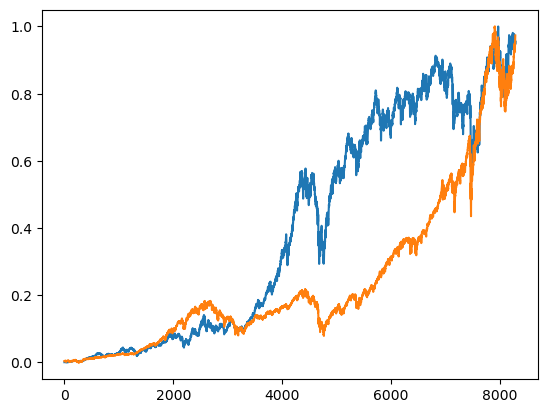

In [19]:
# invertimos el arreglo de numpy porque, vieniendo del dataframe, las fechas comenzaban por la m[as reciente y as[i lo recibi[o numpy
df_for_training_scaled = np.flip(df_for_training_scaled)
plt.plot(df_for_training_scaled)

## Construcción de Dataset

In [20]:
look_back=3
def create_dataset(x, look_back=1):
    dataX, dataY = [], []
    for i in range(len(x)-look_back-1):
        #a = x[i:(i+look_back), 0]
        a = x[i:(i+look_back)]
        dataX.append(a)
        #dataY.append(x[i + look_back, 0])
        dataY.append(x[i + look_back])
    return np.array(dataX), np.array(dataY)

## División Train/Test

In [21]:
train_ratio = 0.7

train_size = int(len(df_for_training_scaled) * train_ratio)
test_size = len(df_for_training_scaled) - train_size
train, test = df_for_training_scaled[0:train_size,:], df_for_training_scaled[train_size:len(df_for_training_scaled),:]

# ----- Generamos los conjuntos X,Y de entrenamiento y prueba -----
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

# ----- reshape input to be [samples, time steps, features] -----
#X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#print(f"Shape of X_train: {X_train.shape}")
#print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (5791, 3, 2)
Shape of X_test: (2480, 3, 2)


## Modelo

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# ------ Creamos el modelo ------
def buildModel():
    model = Sequential()
    model.add(LSTM(800, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    #model.add(LSTM(800, return_sequences=True))
    #model.add(Dropout(0.2))
    #model.add(LSTM(500, return_sequences=True))
    #model.add(Dropout(0.2))
    #model.add(LSTM(300, return_sequences=True))
    #model.add(Dropout(0.2))
    model.add(LSTM(800))
    model.add(Dense(Y_train.shape[1]))
    return model




In [23]:
print('look_back:',look_back)
model = buildModel()
model.summary()

opt = optimizers.Adam(learning_rate=0.0001)
# ------ Compilamos el modelo ------
model.compile(loss='mean_squared_error', metrics=['mae'], optimizer=opt)

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit(X_train, Y_train, epochs=50, batch_size=10, verbose=1,
                    validation_split=0.1,callbacks=[es])

look_back: 3


2023-07-20 21:16:27.519111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 800)            2569600   
                                                                 
 dropout (Dropout)           (None, 3, 800)            0         
                                                                 
 lstm_1 (LSTM)               (None, 800)               5123200   
                                                                 
 dense (Dense)               (None, 2)                 1602      
                                                                 
Total params: 7,694,402
Trainable params: 7,694,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
522/522 [==============================] - 57s 105ms/step - loss: 0.0013 - mae: 0.0141 - val_loss: 6.0631e-05 - val_mae: 0.0055
Epoch 2/100
522/522 [=================

## Obtenemos las predicciones y evaluamos el desempeño de la red

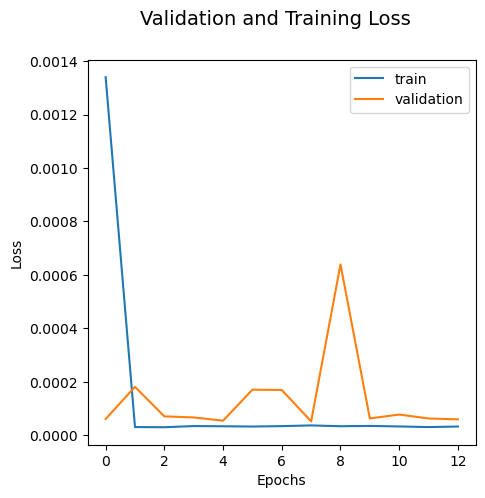

In [24]:
plt.figure(figsize=(5, 5),dpi=100)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Predicciones

In [25]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

78/78 [==============================] - 1s 14ms/step


In [26]:
train_predict = scaler.inverse_transform(train_predict)
#Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
#Y_test = scaler.inverse_transform([Y_test])

In [27]:
model.reset_states()

In [28]:
X_test[0]

array([[0.7182598 , 0.2688486 ],
       [0.716036  , 0.26676452],
       [0.72217968, 0.26791708]])

In [29]:
# input_data = np.reshape(input_data, (1, input_data.shape[0], input_data.shape[1]))
inputData = X_test[0]
inputData = np.reshape(inputData, (1,inputData.shape[0], inputData.shape[1] ))
print(inputData)
nextData = model.predict(inputData)

[[[0.7182598  0.2688486 ]
  [0.716036   0.26676452]
  [0.72217968 0.26791708]]]
1/1 [==============================] - 0s 24ms/step


In [30]:
nextData

array([[0.7230053 , 0.26994222]], dtype=float32)

In [31]:
print(model.evaluate(X_train, Y_train))
print(model.evaluate(X_test, Y_test))

181/181 [==============================] - 3s 15ms/step - loss: 2.5893e-05 - mae: 0.0031
[2.5893201382132247e-05, 0.003096521133556962]
78/78 [==============================] - 1s 15ms/step - loss: 1.4055e-04 - mae: 0.0085
[0.0001405540679115802, 0.00851941853761673]


In [32]:
train_score = math.sqrt(mean_squared_error(Y_train[0], train_predict[0]))
print('Train Score RMSE: %.2f' % (train_score))
test_score = math.sqrt(mean_squared_error(Y_test[0], test_predict[0]))
print('Test Score RMSE: %.2f' % (test_score))

Train Score RMSE: 506.34
Test Score RMSE: 12163.59


In [33]:
df_for_training_scaled.shape

(8279, 2)

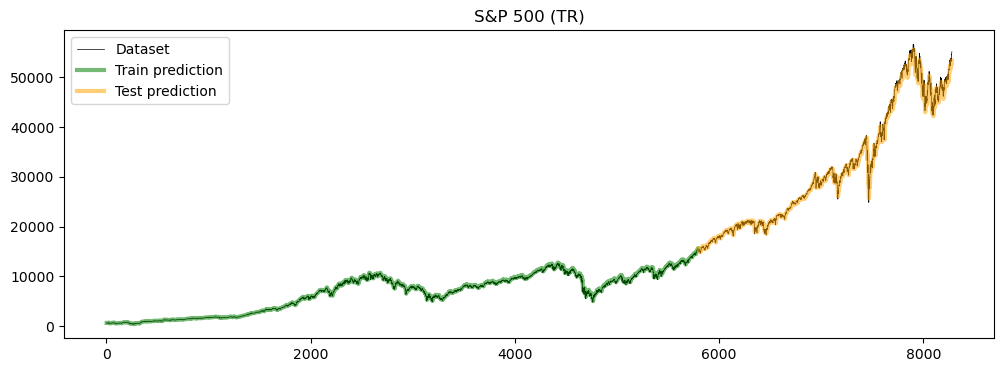

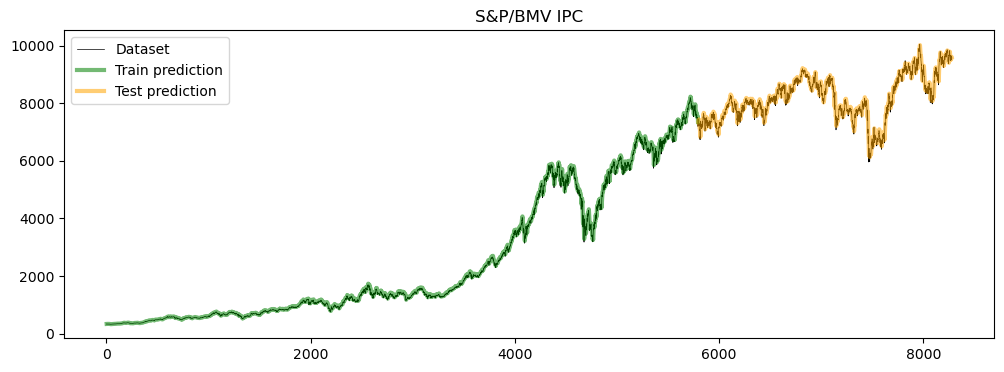

In [34]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataClean)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataClean)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(dataClean)-1, :] = test_predict

# plot baseline and predictions
for i in range(df_for_training_scaled.shape[1])[::-1]:
    plt.figure(figsize=(12,4))
    plt.plot(scaler.inverse_transform(df_for_training_scaled)[:,i],label='Dataset',linestyle='solid',color='black', linewidth=.5)
    plt.plot(trainPredictPlot[:,i],label='Train prediction',color='green',linewidth=3,alpha=0.55)
    plt.plot(testPredictPlot[:,i],label='Test prediction',color='orange',linewidth=3,alpha=0.55)
    plt.title(list(dataClean)[::-1][i])
    plt.legend(loc='best')
    plt.show()